In [1]:
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from typing import Annotated, Any, Literal, TypedDict

import asyncio
import docx
import json
import logging
import mimetypes
import operator
import os
import re
import time

In [2]:
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")
_set_env("AZURE_OPENAI_MODEL_NAME")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("REPROMPTING")
_set_env("MAX_PROMPTS")

REPROMPTING = os.environ["REPROMPTING"].casefold() == "true"
MAX_PROMPTS = int(os.environ["MAX_PROMPTS"])

In [3]:
system_prompt = '''
    You are a GDPR-compliant data privacy assistant. Your role is to detect Personally Identifiable Information (PII) in provided text based on the EU’s General Data Protection Regulation (GDPR).

    PII includes any information relating to an identified or identifiable natural person, either directly (e.g., name, email address, national ID number) or indirectly (e.g., IP address, location data, unique device identifiers, or any data that can identify a person when combined with other information).

    When analyzing documents, you must:
    1. Identify and extract all PII instances.
    2. Categorize each instance.
    3. Determine if it is a direct or indirect identifier.
    4. Justify the classification based on GDPR definitions.

    Maintain strict compliance with GDPR’s definition of personal data as described in Article 4(1).

    Output results in structured JSON array format, suitable for downstream processing.
    If no PII is identified, return an empty JSON array.
'''

user_prompt_template = '''
    ### Instruction:
    Analyze the following document and identify all instances of Personally Identifiable Information (PII) according to the EU's GDPR.

    ### Input:
    {text}

    ### Response:
    For each identified PII instance, return the:
    - text: The extracted text, exactly as it appears in the document
    - category: The PII category (e.g., name, email, phone number, IP address, health data)
    - type: The PII identifier type (direct or indirect)
    - justification: The justification for PII classification

    Output results in structured JSON array format, where each object in the array represents a PII instance.
    If no PII is identified, return an empty JSON array.

    Example:
    [
        {{"text": "John Doe", "category": "name", "type": "direct", "justification": "Identifies an individual directly."}},
        {{"text": "d.joe@brand.co", "category": "email", "type": "direct", "justification": "Identifies an individual directly through their email address."}}
    ]
'''

combination_prompt_template = '''
    ### Instruction:
    You are given a list of structured JSON arrays of JSON objects, where each object in the array represents a Personally Identifiable Information (PII) instance.

    Each PII JSON object contains the following attributes:
    - text
    - category
    - type
    - justification

    Merge all arrays into a single final JSON array which contains all the JSON objects.

    ### Input:
    {pii_lists}

    ### Response:
    Output result in structured JSON array format, where each object in the array represents a PII instance.
'''

In [4]:
import re

class OIFile:
    '''
    This is a class for representing a user-uploaded
    file object. It stores the file ID, the file name,
    the file content and the length of the fiel content.
    It also provides methods to access these attributes
    and to build the document content by normalizing
    newlines, replacing tabs with spaces, and collapsing
    multiple spaces into a single space.

    Attributes:
    - id (str): Unique identifier for the file.
    - name (str): Name of the file.
    - content (str): Normalized content of the file.
    - size (int): Size of the file content in bytes.
    '''
    def __init__(self, id: str, name: str, content: str):
        self.id = id
        self.name = name
        self.content = self._build_document(content)
        self.size = len(self.content)

    def __repr__(self) -> str:
        return f"File(id={self.id}, name={self.name}, size={self.size} bytes)"

    def _build_document(self, text: str) -> str:
        # First normalize consecutive newlines to single newlines
        document = re.sub(r'\n+', ' \n', text)

        # Replace tabs with spaces
        document = re.sub(r'\t', ' ', document)

        # Replace multiple consecutive spaces with a single space
        document = re.sub(r' +', ' ', document)

        return document

    def get_id(self) -> str:
        return self.id

    def get_name(self) -> str:
        return self.name

    def get_content(self) -> str:
        return self.content

    def get_size(self) -> int:
        return self.size

    def to_dict(self) -> dict:
        """
        Export the file object as a dictionary.
        """
        return {
            'id': self.id,
            'name': self.name,
            'content': self.content,
        }

    def update_content(self, content: str) -> None:
        """
        Update the content of the file and recalculate its size.
        """
        self.content = self._build_document(content)
        self.size = len(self.content)

In [5]:
map_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", user_prompt_template),
    ]
)

reduce_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", combination_prompt_template),
    ]
)

In [6]:
class InputState(TypedDict):
    files: list[dict]

class OverallState(TypedDict):
    documents: list[OIFile]
    n_prompts: Annotated[int, lambda a, b: max(a, b)]
    chunked_documents: list[tuple[str]]
    file_ids: Annotated[list[str], operator.add]
    identified_pii_items: Annotated[list[str], operator.add]
    identified_pii_items_by_doc: dict[str, list[str]]
    collected_pii_items: dict[str, str]

class OutputState(TypedDict):
    final_pii_items: list[dict[str, Any]]

class DetectState(TypedDict):
    n_prompts: int
    file_id: str
    content: str

In [7]:
def get_logger(name: str = "pii-detector-langgraph-map-reduce") -> logging.Logger:
    """
    Get a logger with the specified name. If no handlers are set, it will create a default StreamHandler.
    Args:
        name (str): The name of the logger. Defaults to "pii-detector-langgraph-map-reduce".
    Returns:
        logging.Logger: The configured logger instance.
    """
    # Validate the logger name
    if not isinstance(name, str) or not name.strip():
        raise ValueError("Logger name must be a non-empty string.")

    # Get or create a logger with the specified name
    logger = logging.getLogger(name)

    # Ensure the logger is not already configured
    if not logger.hasHandlers():
        # If the logger does not have handlers, we will set it up
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            fmt="%(asctime)s %(levelname)s %(name)s: %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S"
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)

    logger.setLevel(logging.DEBUG)

    return logger

In [8]:
async def chunk_document(
    document: OIFile,
    semaphore: asyncio.Semaphore,
    chunk_size: int = 1024,
    chunk_overlap: int = 128,
    model_name: str = "gpt-35-turbo",
) -> tuple:
    """Asynchronously chunk documents in parallel with limited concurrency"""
    # Create text splitter in a thread to avoid blocking
    def create_splitter_and_split_text(text: str) -> tuple:
        return tuple(RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            encoding_name=model_name,
            model_name=model_name,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            is_separator_regex=False,
            separators=("\n", ". ", "! ", "; ", "... ", " "),
        ).split_text(text))

    # Validate parameters
    if chunk_size <= 0 or chunk_overlap < 0 or chunk_overlap >= chunk_size:
        logger.error(f"Invalid chunk parameters: size={chunk_size}, overlap={chunk_overlap}")
        raise ValueError(
            "Chunk size must be positive, overlap must be non-negative, and overlap must be less than chunk size."
        )

    if not document:
        logger.warning("No documents provided for chunking.")
        return ()

    name = document.get_name()
    text = document.get_content()

    if len(text) < chunk_size:
        logger.warning(f"Document '{name}' is shorter than chunk size. No chunking applied.")
        return tuple(text)

    # Initialize the return value
    split_docs = []

    # Use semaphore to limit concurrent processing
    async with semaphore:
        logger.info(f"Chunking document '{name}' with length {len(text)} characters")

        # Process the text
        split_docs = await asyncio.to_thread(create_splitter_and_split_text, text)

    num_chunks = len(split_docs)
    if num_chunks == 0:
        logger.warning(f"No chunks created while splitting '{name}'")
    else:
        logger.info(f"Split '{name}' into {num_chunks} chunks")

    return tuple(split_docs)

In [9]:
async def mask_content(document: OIFile, file_ids: list[str], pii_items: list[str], semaphore: asyncio.Semaphore) -> OIFile:
    """
    Mask the content of a document based on previously identified PII items.
    This function replaces the PII items in the document content with asterisks of the same length.

    Args:
        document (OIFile): The document to process.
        file_ids (list[str]): List of file IDs corresponding to the documents.
        pii_items (list[str]): List of PII items identified in the documents.
        semaphore (asyncio.Semaphore): Semaphore to limit concurrency.

    Returns:
        OIFile: The document with masked content.
    """
    if not document or not file_ids or not pii_items or not semaphore:
        return document

    content = document.get_content()

    async with semaphore:
        for file_id, pii in zip(file_ids, pii_items):
            if document.get_id() == file_id:
                for item in json.loads(pii):
                    content.replace(item['text'], "*" * len(item['text']))

    document.update_content(content)

    return document

In [10]:
async def load_documents(state: InputState) -> dict[str, list[OIFile]]:
    '''
    Loads documents from the provided state, filtering for DOCX files.

    Args:
        state: InputState containing files to be processed

    Returns:
        A dictionary with a key "documents" containing a list of OIFile instances for each DOCX file found.
    '''
    body_files = state.get("files", [])

    if not body_files:
        logger.error("No files provided for processing.")
        raise ValueError("No files provided for processing.")

    logger.debug(f"Received {len(body_files)} files for processing")

    file_infos = []

    for entry in body_files:
        file = entry.get("file", {})

        # Only process DOCX files
        if file['filename'].casefold().endswith('.docx') and file['meta']['content_type'] == \
            'application/vnd.openxmlformats-officedocument.wordprocessingml.document':
            # Create an OIFile instance and append it to the list
            file_infos.append(
                OIFile(file['id'], file['filename'], file['data']['content'])
            )

    return {"documents": file_infos}

In [11]:
async def split_documents(state: OverallState) -> dict[str, list[tuple[str]]]:
    '''
    Splits documents into chunks using the RecursiveCharacterTextSplitter.

    Args:
        state: OverallState containing documents to be chunked

    Returns:
        A dictionary with a key "chunked_documents" containing a list of tuples, each tuple
        representing the chunks of a document.
    '''
    documents = state.get("documents", [])
    n_prompts = state.get("n_prompts", 0)

    if not documents:
        logger.warning("No documents provided for chunking.")
        return {"chunked_documents": []}

    # Create semaphore to limit concurrency
    semaphore = asyncio.Semaphore(25)

    if REPROMPTING and n_prompts > 0:
        logger.info(f"Reprompting requested. Masking documents contents before chunking.")

        file_ids = state.get("file_ids", [])
        pii_items = state.get("identified_pii_items", [])

        # Mask documents contents concurrently and gather results
        tasks = [mask_content(doc, file_ids, pii_items, semaphore) for doc in documents]
        documents = await asyncio.gather(*tasks)

    logger.debug(f"Chunking {len(documents)} documents")

    # Process documents concurrently and gather results
    tasks = [chunk_document(doc, semaphore) for doc in documents]
    chunked_documents = await asyncio.gather(*tasks)

    return {"chunked_documents": chunked_documents}

In [12]:
async def map_chunks(state: OverallState):
    '''
    Maps the chunked documents to the identify_pii_items function.

    This function creates Send objects for each chunk of each document,
    allowing the identify_pii_items function to process them in parallel.

    Args:
        state: OverallState containing chunked documents

    Returns:
        A list of Send objects, each containing a chunk of text and its associated file ID.
    '''
    # When used with add_conditional_edges, this function should return Send objects directly
    sends = []

    n_prompts = state.get("n_prompts", 0)
    files_ids = [doc.get_id() for doc in state.get("documents", [])]
    files_chunks = state.get('chunked_documents', [])

    # For each document in the chunked_documents (maintaining document separation)
    for file_id, chunks in zip(files_ids, files_chunks):
        # For each chunk in the document
        for content in chunks:
            # Create Send objects with document index metadata
            sends.append(
                Send("identify_pii_items",
                     {
                        "n_prompts": n_prompts,
                        "file_id": file_id,
                        "content": content,
                    }
                )
            )

    return sends  # Return Send objects directly without wrapping in a dictionary

In [13]:
async def identify_pii_items(state: DetectState):
    '''
    Identifies PII items in the provided text using a language model.

    This function takes the text content and file ID from the state,
    invokes the language model with a prompt, and returns the identified PII items.

    Args:
        state: DetectState containing the text content and file ID

    Returns:
        A dictionary with identified PII items and their associated file ID.

    This function is designed to be used with the map_chunks function,
    which provides the necessary text and file ID for processing.

    It processes each chunk of text independently, allowing for parallel PII detection.

    The function expects the text to be in a specific format (JSON) and returns the identified
    PII items in a structured format for further processing.

    If the content is not in the expected format, it will attempt to clean it up before returning.

    This function is asynchronous and designed to work within a larger state management system,
    allowing for efficient processing of multiple text chunks in parallel.
    '''
    n_prompts = state.get("n_prompts", 0)
    file_id = state.get("file_id", "")
    text = state.get("content", "")

    prompt = map_prompt.invoke({'text': text})
    response = await llm.ainvoke(prompt)
    content = response.content

    if content.startswith("```json\n") and content.endswith("\n```"):
        content = content.replace("```json\n", "").replace("\n```", "").strip()

    # Return with document and chunk indexes to maintain structure
    return {
        "n_prompts": n_prompts + 1,
        "file_ids": [file_id],
        "identified_pii_items": [content],
    }

In [14]:
async def reprompt_to_identify_more_pii_items(state: OverallState) -> Literal["split_documents", "organize_pii_by_file"]:
    if REPROMPTING and state.get("n_prompts", 0) < MAX_PROMPTS:
        return "split_documents"
    else:
        return "organize_pii_by_file"

In [15]:
async def organize_pii_by_file(state: OverallState):
    '''
    Organizes identified PII items by their associated document IDs.

    This function takes the identified PII items and their corresponding file IDs
    from the state, and groups them by document ID.

    Args:
        state: OverallState containing identified PII items and file IDs

    Returns:
        A dictionary with a key "identified_pii_items_by_doc" containing a mapping of file IDs to their respective PII items.

    This function is used to structure the results of PII detection by document,
    allowing for easier aggregation and processing of PII items across multiple documents.

    It collects all identified PII items and groups them by their associated document IDs,
    enabling subsequent steps in the PII detection pipeline to work with a structured view of the data
    and to combine PII items from different chunks of the same document.

    This is particularly useful for scenarios where documents are split into chunks for processing,
    and the results need to be aggregated back into a coherent structure for further analysis or reporting.
    '''
    # Initialize structure to hold results by document
    results_by_doc = {}

    # Collect all items with their document indexes
    for file_id, items in zip(state.get("file_ids", []), state.get("identified_pii_items", [])):
        if file_id not in results_by_doc:
            results_by_doc[file_id] = []
        results_by_doc[file_id].append(items)

    return {"identified_pii_items_by_doc": results_by_doc}

In [16]:
async def combine_file_pii_items(state: OverallState):
    '''
    Combines identified PII items from different chunks of the same document into a single structured output.

    This function takes the identified PII items grouped by document ID and combines them into a single JSON structure
    for each document, ensuring that all PII items are aggregated correctly.

    Args:
        state: OverallState containing identified PII items by document

    Returns:
        A dictionary with a key "collected_pii_items" containing a mapping of file IDs to their respective combined PII items.

    This function is used to aggregate PII items from multiple chunks of the same document into a single coherent structure.

    It processes each document's identified PII items, invoking a language model to combine them into a structured JSON format.

    The resulting dictionary maps each file ID to its corresponding combined PII items,
    which can then be used for further processing or reporting.
    '''
    collected_pii_items = {}

    for file_id, pii_items in state['identified_pii_items_by_doc'].items():
        prompt = reduce_prompt.invoke({'pii_lists': ',\n        '.join([f'{json.loads(pii)}' for pii in pii_items])})
        response = await llm.ainvoke(prompt)
        content = response.content

        if content.startswith("```json\n") and content.endswith("\n```"):
            content = content.replace("```json\n", "").replace("\n```", "").strip()

        collected_pii_items[file_id] = content

    return {'collected_pii_items': collected_pii_items}

In [17]:
async def postprocess_pii_items(state: OverallState):
    '''
    Post-processes the collected PII items to remove duplicates based on 'text' and 'category' keys.

    This function takes the collected PII items from the state, parses them, and removes any duplicate entries
    based on the combination of 'text' and 'category' fields.

    Args:
        state: OverallState containing collected PII items
    Returns:
        A dictionary with a key "final_pii_items" containing a list of dictionaries, each representing a file ID and its unique PII items.

    This function is used to ensure that the final output of PII items is clean and free from duplicates,
    which is essential for accurate reporting and further processing of PII data.

    It processes each file's PII items, ensuring that only unique items are retained based on their 'text' and 'category' fields.

    The function efficiently handles the deduplication process by using a set to track unique items and creating a unique key for
    each PII item based on these fields, allowing for quick lookups and ensuring that the final output is concise and accurate.

    The function returns a structured output that can be easily consumed by downstream processes or reporting tools.

    This function is designed to be efficient and scalable, handling potentially large sets of PII items
    while ensuring that the final output is both unique and structured.

    The final output is structured as a list of dictionaries, where each dictionary contains the file ID and its corresponding
    unique PII items, ready for downstream processing or reporting.
    '''
    postprocessed_pii_items = []

    for file_id, pii_items in state['collected_pii_items'].items():
        pii_items = json.loads(pii_items)

        # Remove duplicates based on 'text' and 'category' fields
        unique_items = set()
        unique_pii_items = []

        for item in pii_items:
            # Create a hashable key from the 'text' and 'category' fields
            item_key = f"{item['text']}_{item['category']}"

            # Only add items we haven't seen before
            if item_key not in unique_items:
                unique_items.add(item_key)
                unique_pii_items.append(item)

        postprocessed_pii_items.append(
            {
                "id": file_id,
                "pii": unique_pii_items,
            }
        )

    return {'final_pii_items': postprocessed_pii_items}

In [18]:
# Define the graph
builder = StateGraph(OverallState, input=InputState, output=OutputState)

# Add nodes with async functions
builder.add_node("load_documents", load_documents)
builder.add_node("split_documents", split_documents)
builder.add_node("identify_pii_items", identify_pii_items)
builder.add_node("organize_pii_by_file", organize_pii_by_file)
builder.add_node("combine_file_pii_items", combine_file_pii_items)
builder.add_node("postprocess_pii_items", postprocess_pii_items)

# Add edges (with or without conditional routing)
builder.add_edge(START, "load_documents")
builder.add_edge("load_documents", "split_documents")
builder.add_conditional_edges("split_documents", map_chunks, ["identify_pii_items"])
builder.add_conditional_edges("identify_pii_items", reprompt_to_identify_more_pii_items, ["split_documents", "organize_pii_by_file"])
builder.add_edge("organize_pii_by_file", "combine_file_pii_items")
builder.add_edge("combine_file_pii_items", "postprocess_pii_items")
builder.add_edge("postprocess_pii_items", END)

# Compile the graph
graph = builder.compile(
    interrupt_before=[],
    interrupt_after=[],
)
graph.name = "PiiDetectionLangGraph"

# Create main agent instance
app = graph

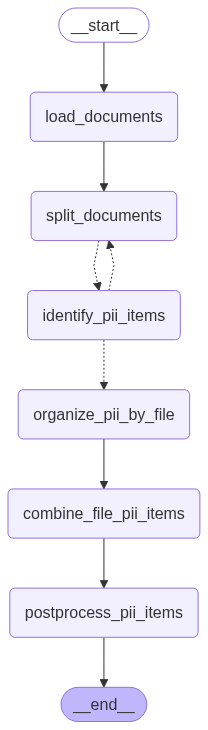

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [20]:
logger = get_logger()

In [21]:
def load_local_documents(dir_path: str, max_concurrency: int=10) -> list:
    """
    Load documents from a local directory.
    """
    # Resolve directory synchronously
    if not os.path.isabs(dir_path):
        dir_path = os.path.join(os.getcwd(), dir_path)

    if not os.path.exists(dir_path) or not os.path.isdir(dir_path):
        return []

    # List files synchronously
    file_paths = [
        os.path.join(dir_path, f) for f in os.listdir(dir_path)
        if os.path.isfile(os.path.join(dir_path, f))
    ]

    if not file_paths:
        logger.warning(f"No files found in directory: {dir_path}")
        return []

    # Process files sequentially in a totally synchronous manner
    results = []

    for i, file_path in enumerate(file_paths):
        try:
            content = _extract_file_content(file_path)
            file_info = _extract_file_metadata(file_path)
            file_info["file"]["id"] = str(i)
            file_info["file"]["data"] = {"content": content}
            logger.info(f"Processed: {file_path}")
            results.append(file_info)
        except Exception as e:
            logger.error(f"Error processing {file_path}: {e}")
            results.append({})

    files = [result for result in results if result]
    logger.info(f"Successfully processed {len(files)}/{len(file_paths)} files")

    return files

# Add synchronous versions of your async functions
def _extract_file_metadata(file_path: str) -> dict:
    """Synchronous version of _extract_file_metadata"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    filename = os.path.basename(file_path)
    content_type = _get_file_mime_type(file_path)
    created_at = int(time.time())

    return {
        "file": {
            "filename": filename,
            "created_at": created_at,
            "meta": {"content_type": content_type or "application/octet-stream"}
        }
    }

def _get_file_mime_type(file_path: str) -> str:
    """Synchronous version of _get_file_mime_type"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    mime_type, _ = mimetypes.guess_type(file_path)

    if mime_type is None:
        with open(file_path, 'rb') as f:
            file_start = f.read(512)

        if file_start.startswith(b'%PDF'):
            return 'application/pdf'
        elif file_start.startswith(b'\x50\x4B\x03\x04'):
            return 'application/zip'

        return 'application/octet-stream'

    return mime_type

def _extract_file_content(file_path: str) -> str:
    """Synchronous version of _extract_file_content"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    extension = os.path.splitext(file_path)[1].casefold()

    # File type handlers
    if extension == ".txt":
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    elif extension == ".docx":
        doc = docx.Document(file_path)
        return "\n".join([p.text for p in doc.paragraphs])
    elif extension in [".rtf", ".odt", ".md"]:
        return pypandoc.convert_file(file_path, "plain")
    else:
        raise ValueError(f"Unsupported file format: {extension}")

In [ ]:
docx_files = load_local_documents('docx_files')

In [23]:
llm = AzureChatOpenAI(model=os.environ["AZURE_OPENAI_MODEL_NAME"], api_version=os.environ["AZURE_OPENAI_API_VERSION"], temperature=0.1)

In [ ]:
last_step = None
async for step in app.astream(
    {'files': docx_files},
    {"recursion_limit": 20},
):
    print(list(step.keys()))
    last_step = step

In [ ]:
last_step['postprocess_pii_items']['final_pii_items']